##**Problem Statement:** NO2 Emission Factor Estimation from Global Power Plant.


##**Step 1:** Data Collection

In [ ]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset

'''In Dataset, Columns (10) have mixed types so we can specify the data type for
that column explicitly when importing the dataset or set the low_memory parameter to False'''

power_plants_data = pd.read_csv('/content/drive/MyDrive/global_power_plant_database.csv', low_memory=False)

##**Step 2:** Data Exploration & Preprocessing

In [ ]:
power_plants_data.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.1190,Hydro,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.7950,Solar,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.7920,Solar,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.556,69.4787,Hydro,NaN,NaN,...,225.06,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.641,69.7170,Hydro,NaN,NaN,...,406.16,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In [ ]:
power_plants_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34936 entries, 0 to 34935
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         34936 non-null  object 
 1   country_long                    34936 non-null  object 
 2   name                            34936 non-null  object 
 3   gppd_idnr                       34936 non-null  object 
 4   capacity_mw                     34936 non-null  float64
 5   latitude                        34936 non-null  float64
 6   longitude                       34936 non-null  float64
 7   primary_fuel                    34936 non-null  object 
 8   other_fuel1                     1944 non-null   object 
 9   other_fuel2                     276 non-null    object 
 10  other_fuel3                     92 non-null     object 
 11  commissioning_year              17447 non-null  float64
 12  owner                           

In [ ]:
power_plants_data.shape

(34936, 36)

In [ ]:
# Check for missing values

missing_values = power_plants_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 country                               0
country_long                          0
name                                  0
gppd_idnr                             0
capacity_mw                           0
latitude                              0
longitude                             0
primary_fuel                          0
other_fuel1                       32992
other_fuel2                       34660
other_fuel3                       34844
commissioning_year                17489
owner                             14068
source                               15
url                                  18
geolocation_source                  419
wepp_id                           18702
year_of_capacity_data             20049
generation_gwh_2013               28519
generation_gwh_2014               27710
generation_gwh_2015               26733
generation_gwh_2016               25792
generation_gwh_2017               25436
generation_gwh_2018               25299
generation_gwh_2019    

In [ ]:
# Columns with missing values
columns_with_missing = ['capacity_mw', 'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
                        'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
                        'estimated_generation_gwh_2017']

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
power_plants_data[columns_with_missing] = imputer.fit_transform(power_plants_data[columns_with_missing])


##**Step 3:** Data Visualization

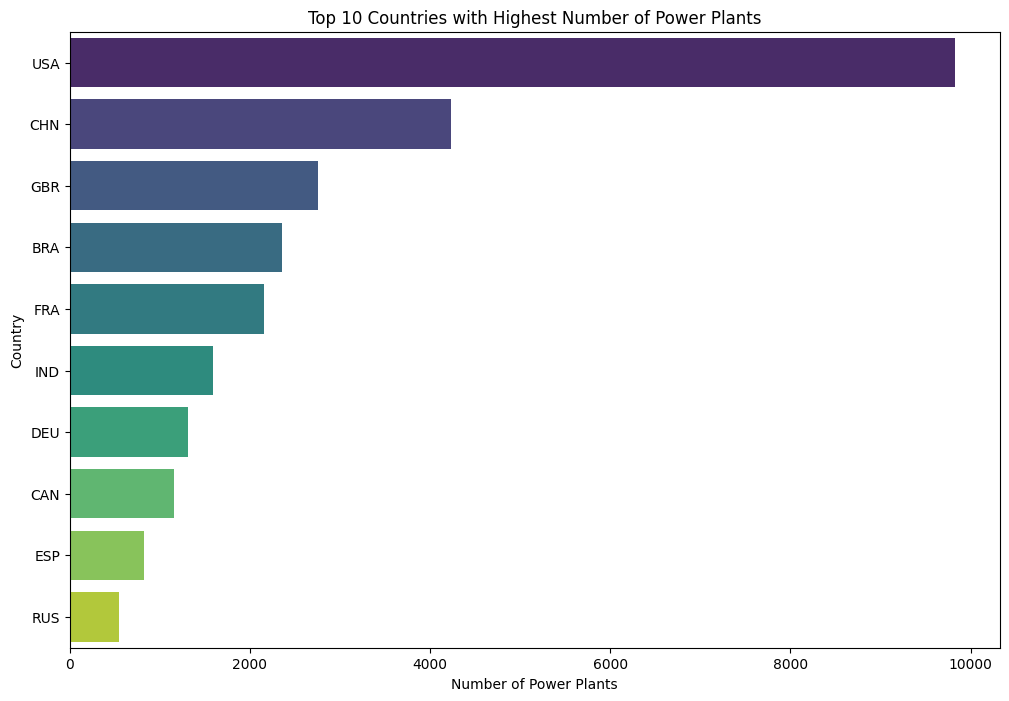

In [ ]:
# Distribution of power plants across countries

N = 10 # Change N to display the top N countries
plt.figure(figsize=(12, 8))
top_countries = power_plants_data['country'].value_counts().nlargest(N)
sns.barplot(x=top_countries.values, y=top_countries.index, hue=top_countries.index, palette='viridis', legend=False)
plt.title(f'Top {N} Countries with Highest Number of Power Plants')
plt.xlabel('Number of Power Plants')
plt.ylabel('Country')
plt.show()

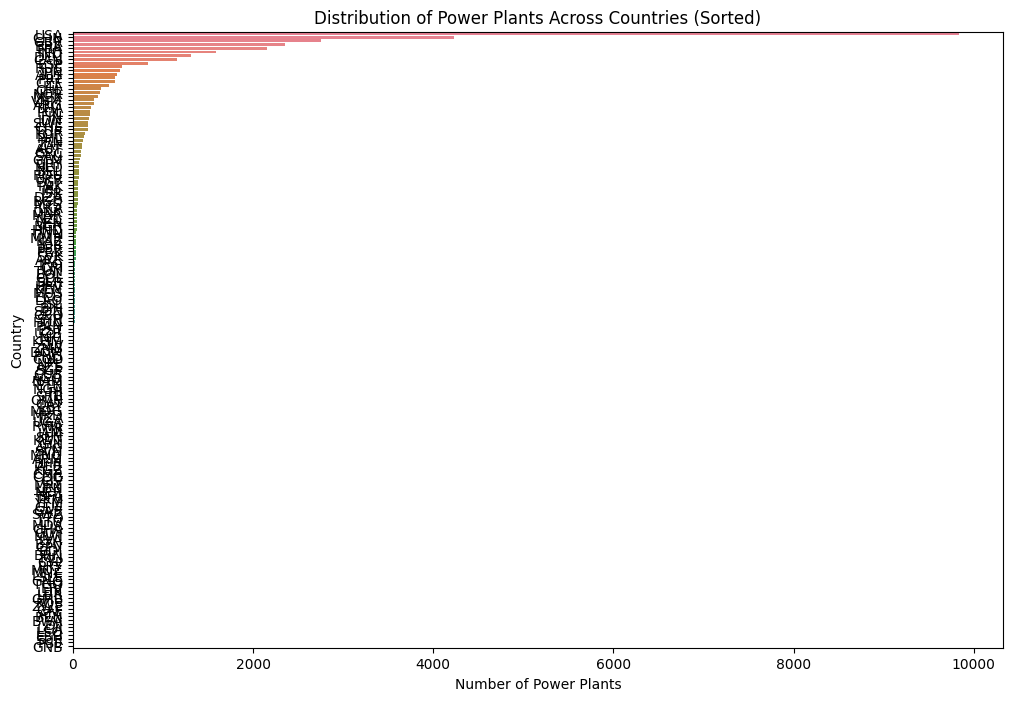

In [ ]:
# Distribution of power plants across countries (in Horizontal Bar Plot with All Countries Sorted)

plt.figure(figsize=(12, 8))
sorted_countries = power_plants_data['country'].value_counts().sort_values(ascending=False)
sns.barplot(x=sorted_countries.values, y=sorted_countries.index, hue=sorted_countries.index, dodge=False)
plt.title('Distribution of Power Plants Across Countries (Sorted)')
plt.xlabel('Number of Power Plants')
plt.ylabel('Country')
plt.show()

In [ ]:
# Plot the locations of power plants on a map

fig = px.scatter_geo(power_plants_data, lat='latitude', lon='longitude', scope='world', title='Locations of Power Plants')
fig.show()

##**Step 4:** Calculation of Emission Factor value

###Approach 1: NO2 Emission factor (without any use of algorithms)

In [ ]:
# Calculate overall estimated generation from 2013 to 2017

power_plants_data['overall_estimated_generation_gwh'] = power_plants_data[['estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
                                             'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
                                             'estimated_generation_gwh_2017']].sum(axis=1)

total_emissions =  power_plants_data['overall_estimated_generation_gwh'].sum()  # Total emissions from all power plants
total_capacity =  power_plants_data['capacity_mw'].sum()  # Total capacity of all power plants

emission_factor_overall = total_emissions / total_capacity
print("Emission Factor of NO2 for 2013-2017:", emission_factor_overall)


Emission Factor of NO2 for 2013-2017: 10.220357755720341


####NO2 Emission factor calculation using **Linear Regression**

In [ ]:
# Step 1: Select relevant columns and clean the data -> capacity_mw and estimated_generation_gwh from 2013-17 (overall)

# Step 2: Split data into training and testing sets
X = power_plants_data[['capacity_mw']]  # Predictor variable(s)
y = power_plants_data['overall_estimated_generation_gwh']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

# Step 5: Predict emission factor
emission_factor_linear = model.predict(X)

print("Emission Factor for 2013-2017 (Linear Regression):", emission_factor_linear.mean())


Mean Squared Error: 7426923.36833941
Mean Absolute Error: 902.5820868390493
R-squared Score: 0.5670563311568131
Emission Factor for 2013-2017 (Linear Regression): 1672.7494238629447


####NO2 Emission factor calculation using **Random Forest Regression**

In [ ]:
# Select features and target variable
X = power_plants_data[['capacity_mw']]
y = power_plants_data['overall_estimated_generation_gwh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_regressor.predict(X_test)

# Calculate the emission factor using the predicted overall estimated generation and total capacity
total_predicted_emissions = sum(y_pred)
total_capacity = power_plants_data['capacity_mw'].sum()
emission_factor_random = total_predicted_emissions / total_capacity

print("Emission Factor for 2013-2017 (Random Forest Regression):", emission_factor_random )


Emission Factor for 2013-2017 (Random Forest Regression): 2.082773430791838


####NO2 calculation using **Gradient Boosting Regression**

In [ ]:
# Assuming 'X' contains features and 'y' contains the target variable (emission factors)
X = power_plants_data.drop(columns=['capacity_mw'])  # Features
y = power_plants_data['overall_estimated_generation_gwh']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Perform one-hot encoding for categorical variables
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough')

# Initialize SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Apply imputation and one-hot encoding
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

# Fit the imputer on the training data and transform both training and testing data
X_train_encoded = imputer.fit_transform(X_train_encoded)
X_test_encoded = imputer.transform(X_test_encoded)

# Initialize and train the Gradient Boosting Regression model
model = GradientBoostingRegressor()
model.fit(X_train_encoded, y_train)

# Predict on the testing set
y_pred = model.predict(X_test_encoded)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Print the predicted values (emission factors)
print("Predicted Emission Factors:", y_pred)

# Step 6: Predict emission factor
emission_factor_gradientboosting = model.predict(X_test_encoded)

print("Emission Factor for 2013-2017 (Gradient Boosting Regression):", emission_factor_gradientboosting.mean())

Mean Absolute Error: 22.030886872159478
Mean Squared Error: 5677.416494148371
R-squared: 0.999669041754624
Predicted Emission Factors: [ 958.72839736  954.73175671   35.05959389 ... 1667.61054485 1004.05217877
   28.14034245]
Emission Factor for 2013-2017 (Gradient Boosting Regression): 1671.6430175296969


####NO2 Emission factor calculation using **Decision Tree**

In [ ]:
# Step 1: Select relevant features and target variable
X = power_plants_data[['capacity_mw']]
y = power_plants_data['overall_estimated_generation_gwh']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Decision Tree regression model
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = dt_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Step 5: Predict the overall estimated generation
total_estimated_generation = power_plants_data[['estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
                                                'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
                                                'estimated_generation_gwh_2017']].sum(axis=1)

emission_factor_decisiontree = dt_regressor.predict(X_test)
print("Predicted Emission Factors:", emission_factor_decisiontree)

print("Emission Factor for 2013-2017 (Decision Tree Regression):", emission_factor_decisiontree.mean())

Mean Absolute Error: 900.6594170415897
Mean Squared Error: 17622376.137801327
R-squared Score: -0.02727546797621283
Predicted Emission Factors: [ 22.73       718.58976987 516.59839352 ... 403.50735386 716.05519456
  10.15      ]
Emission Factor for 2013-2017 (Decision Tree Regression): 1727.2551772085255


###Approach 2: NO2 Emission factor calculation using **K-means Clustering**

Emission Factor for 2013-2017 Cluster 1: 10.51 GWh/MW
Emission Factor for 2013-2017 Cluster 2: 9.00 GWh/MW
Emission Factor for 2013-2017 Cluster 3: 21.22 GWh/MW


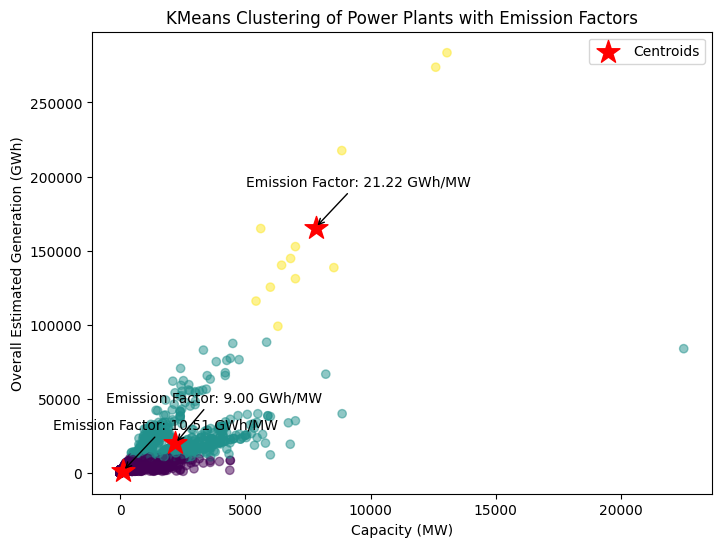

In [ ]:
# Select relevant features for clustering
X = power_plants_data[['capacity_mw', 'overall_estimated_generation_gwh']]

# Choose the number of clusters (k)
k = 3

# Initialize KMeans model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly setting n_init

# Fit the KMeans model to the data
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the dataset
power_plants_data['cluster'] = cluster_labels

# Calculate emission factor for each cluster
emission_factors_kmeans = []
for i in range(k):
    cluster_data = power_plants_data[power_plants_data['cluster'] == i]
    total_capacity_cluster = cluster_data['capacity_mw'].sum()
    total_generation_cluster = cluster_data['overall_estimated_generation_gwh'].sum()
    emission_factor_cluster = total_generation_cluster / total_capacity_cluster
    emission_factors_kmeans.append(emission_factor_cluster)

# Print emission factors for each cluster
for i, factor in enumerate(emission_factors_kmeans):
    print(f"Emission Factor for 2013-2017 Cluster {i+1}: {factor:.2f} GWh/MW")

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X['capacity_mw'], X['overall_estimated_generation_gwh'], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*', label='Centroids')
plt.xlabel('Capacity (MW)')
plt.ylabel('Overall Estimated Generation (GWh)')
plt.title('KMeans Clustering of Power Plants with Emission Factors')
plt.legend()

# Annotate emission factors on the plot
for i, txt in enumerate(emission_factors_kmeans):
    plt.annotate(f"Emission Factor: {txt:.2f} GWh/MW", (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]), xytext=(-50, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

plt.show()

##**Step 5:** Comparison of Emission Factor values from algorithms used

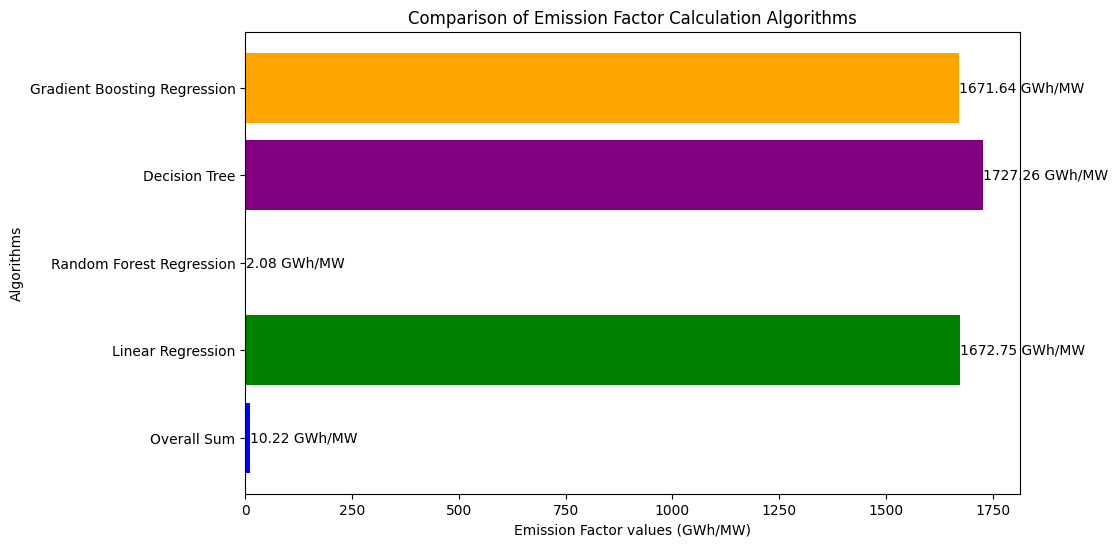

In [ ]:
# Calculate the mean of each array
emission_factor_decisionTree_mean = np.mean(emission_factor_decisiontree)
emission_factor_gradientboosting_mean = np.mean(emission_factor_gradientboosting)

# Append the mean values to the emission_factors list
emission_factors = [emission_factor_overall.mean(), emission_factor_linear.mean(), emission_factor_random.mean()]
emission_factors.extend([emission_factor_decisionTree_mean, emission_factor_gradientboosting_mean])

# Now, we should have 6 values in emission_factors list
# Labels for each algorithm
labels = ['Overall Sum', 'Linear Regression', 'Random Forest Regression', 'Decision Tree', 'Gradient Boosting Regression']

# Plotting the emission factor values with annotations
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, emission_factors, color=['blue', 'green', 'red' , 'purple', 'orange'])

# Adding annotations for the calculated values
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{emission_factors[i]:.2f} GWh/MW', va='center', ha='left')

plt.xlabel('Emission Factor values (GWh/MW)')
plt.ylabel('Algorithms')
plt.title('Comparison of Emission Factor Calculation Algorithms')

plt.show()

##**Conclusion:**
1. This project aims to estimate global NO2 emission factors for power plants and their impact.
2. It calculates overall estimated generation from 2013 to 2017 and derives NO2 emission factors.
3. In this project, Regression models predict generation and NO2 emission factors and KMeans clustering groups the power plants by capacity and generation.
4. In conclusion, the total estimated generation and NO2 emission variables were predicted using regression models. The results showed  the  emission factors obtained are Random Forest is 2.08 gwh/Mw, Gradient Boosting Regression is 1671.64 gwh/Mw, and Linear Regression is 1672.75 gwh/Mw and Decision Tree Regression: 1727.26 gwh/Mw.
5. Thus, it is evident that the dataset performs better when using Linear Regression, Gradient Boosting Regression, and Decision Tree Regression to determine the Emission factor.
6. Furthermore, power plants were grouped according to their capacity and generation with the help of KMeans clustering. This revealed an emission factor of 21.22 gwh/MW, which made it easier to compare different clusters.


##Here we have computed the India and UK's No2 Emission Factor and visualised it using the Folium Library.

In [ ]:
# Power plants located in India
indian_power_plants = power_plants_data[(power_plants_data['country_long'] == 'India')]
# Create a map centered around India
india_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Initialize cnt
cnt = 0

# Add markers for each power plant in India
for index, row in indian_power_plants.iterrows():
    cnt += 1
    folium.Marker([row['latitude'], row['longitude']], tooltip=row['name']).add_to(india_map)

# Save the map as an HTML file
india_map.save("india_power_plants_map.html")

# Display the map
india_map


In [ ]:
# Filter power plants located in India
indian_power_plants = power_plants_data[power_plants_data['country_long'] == 'India'].copy()

# Calculate overall estimated generation for Indian power plants
indian_power_plants['overall_estimated_generation_gwh'] = indian_power_plants[[
    'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
    'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
    'estimated_generation_gwh_2017']].sum(axis=1)

# Calculate total emissions from Indian power plants
total_emissions_india = indian_power_plants['overall_estimated_generation_gwh'].sum()

# Calculate total capacity of Indian power plants
total_capacity_india = indian_power_plants['capacity_mw'].sum()

# Calculate emission factor for Indian power plants
emission_factor_india = total_emissions_india / total_capacity_india
print("Emission Factor of NO2 for power plants in India:", emission_factor_india)

Emission Factor of NO2 for power plants in India: 8.879330184093941


In [ ]:
uk_power_plants = power_plants_data[(power_plants_data['country_long'] == 'United Kingdom')]
# Create a map centered around India
uk_map = folium.Map(location=[55.3781, -3.4360], zoom_start=5)

cnt=0
# Add markers for each power plant in India
for index, row in uk_power_plants.iterrows():
    cnt=cnt+1
    folium.Marker([row['latitude'], row['longitude']], tooltip=row['name']).add_to(uk_map)
print(cnt)
# Save the map as an HTML file
uk_map.save("uk_power_plants_map.html")

# Display the map
uk_map

2751


In [ ]:
# Power plants located in UK
uk_power_plants = power_plants_data[power_plants_data['country_long'] == 'United Kingdom'].copy()

# Calculate overall estimated generation for Indian power plants
uk_power_plants['overall_estimated_generation_gwh'] = uk_power_plants[[
    'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
    'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
    'estimated_generation_gwh_2017']].sum(axis=1)

# Calculate total emissions from Indian power plants
total_emissions_uk = uk_power_plants['overall_estimated_generation_gwh'].sum()

# Calculate total capacity of Indian power plants
total_capacity_uk = uk_power_plants['capacity_mw'].sum()

# Calculate emission factor for Indian power plants
emission_factor_uk = total_emissions_uk / total_capacity_uk
print("Emission Factor of NO2 for power plants in UK:", emission_factor_uk)

Emission Factor of NO2 for power plants in UK: 20.7847908686716


###Dataset Link: [global-power-plant-database-technical-note-v1.0.pdf](https://)

###[Link of the Referred Project](https://www.kaggle.com/code/meenakshiramaswamy/ds4g-eie-no2emission-calcef-buildmodel/notebook)
